# Анализ оттока клиентов банка
Перед нами данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов и Рыбинск.

### Заказчик: отдел маркетинга

### Цель проекта 

Проанализировать клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.

### Этапы исследования

 1.Загрузка датасета и изучение общей информации;
 
 2.Предобработка данных; 
 
 3.Исследовательский анализ данных;
 
 4.Статистический анализ данных;
 
 5.Вывод и рекомендации;
 
 6.Подготовка презентацию.
    
    
### Описание данных

Данные о клиентах содержаться в файле `bank_scrooge.csv`
 
 - `userid` — идентификатор пользователя,
 - `score` — баллы кредитного скоринга,
 - `City` — город,
 - `Gender` — пол,
 - `Age` — возраст,
 - `equity`  — оценка собственности,
 - `Balance` — баланс на счёте,
 - `Products` — количество продуктов, которыми пользуется клиент,
 - `CreditCard` — есть ли кредитная карта,
 - `last_activity` — активный клиент,
 - `estimated_salary` — заработная плата клиента,
 - `Churn` — ушёл или нет.
 
 
 ### Материалы
Презентация https://disk.yandex.ru/d/B2Qqy7MSDbcdlQ

Дашборд https://public.tableau.com/app/profile/khana.merzlikina/viz/_16867743375580/Dashboard1?publish=yes

### Изучение общей информации

In [32]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [33]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from scipy import stats as st

In [34]:
# чтение файла с данными

try:
    data = (
        pd.read_csv('/datasets/bank_scrooge.csv')
    )


except:
    data = (
        pd.read_csv('bank_scrooge.csv')
    )

In [35]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Итак, мы видим, что в датасете 10000 строк и 12 столбцов. Названия столбцов необходимо переименовать в соответствии с хорошим стилем. Также в столбцах `age` и `balance` есть пропуски. Типы данных так же нужно будет изменить и проверить на дубликаты.

### Предобработка данных

In [36]:
# приведем названия столбцов к нижнему регистру.
data.columns = data.columns.str.lower()
# переименуем столбец userid
data.rename(columns={'userid':'user_id'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Посмотрим сколько пропусков в столбцах в процентах.

In [37]:
data.isna().sum()/len(data)* 100

user_id           0.00
score             0.00
city              0.00
gender            0.00
age               0.26
equity            0.00
balance          22.95
products          0.00
credit_card       0.00
last_activity     0.00
est_salary        0.00
churn             0.00
dtype: float64

Посмотрим на пропуски в столбце `balance`

In [38]:
# создадим датасет с пропусками в балансе
data_balance_nan = data.query('balance.isna() == True')
#сгруппируем по городам и посмотрим активность и отточность этих клиентов
data_balance_nan = data_balance_nan.groupby('city').agg({'user_id' : 'count', 'last_activity' : 'sum', 'churn' : 'sum'}).reset_index() 
data_balance_nan

,city,user_id,last_activity,churn
0,Ростов,235,134,1
1,Рыбинск,593,332,4
2,Ярославль,1467,795,8


Из таблицы видно, что в каждом городе есть небольшая часть клиентов с пропусками в балансе. Пропуски есть как у активных клиентов так и неактивных. Также пропуски не связаны с отточностью клиентов. Поскольку пропусков много (22,95%) удалить такой объем мы не можем, но и корректно заполнить их никак. Оставим как есть. В столбце `age` пропусков всего 0,26%, так что мы можем смело удалять пропуски. 

In [39]:
#удаляем пропуски
data = data.dropna(subset=['age'])

Далее заменим тип данных у столбцов `score`, `age`. 

In [40]:
# заменим тип данных
data['score'] = data['score'].astype('int64')
data['age'] = data['age'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9974 non-null   int64  
 1   score          9974 non-null   int64  
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   int64  
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1013.0+ KB


Проверим на дубликаты

In [41]:
#проверим на явные дубликаты
data.duplicated().sum()

0

Явных дубликатов нет. Теперь проверим столбец `user_id` на дубликаты, т.к. у каждого клиента должен быть свой уникальных id. 

In [42]:
#data.duplicated(['user_id']).sum()/len(data)* 100
data.duplicated(['user_id']).sum()

50

Мы видим, что есть 50 пар id. Выведем их на экран.

In [43]:
data[data.duplicated(['user_id'], keep=False)].sort_values(by='user_id').head(50)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1
7694,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1
7542,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1
5896,120258,905,Ярославль,М,30,0,NaN,1,1,1,146427.96,0
1411,123461,829,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1
8638,123461,934,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0
9775,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0
8164,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1


Данные у повторяющихся id разные. Мы видим, что это клиенты из Рыбинска и Ярославля, а также можно обратить внимание, что у одного и того же id один клиент отточный. Вероятно это ошибка при заполнении, когда клиент уходил из банка его номер присваивался новому из другого города. Возможно у них не было общей базы при заполнении. Удалять не будем.


Посмотрим на уникальные значения в столбцах с названием города и пола.

In [44]:
data['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [45]:
data['gender'].unique()

array(['Ж', 'М'], dtype=object)

In [46]:
data.shape[0]

9974

Итак, была проведена предобработка дааных. Данные были проверены на явные и неявные дубликаты. Пропуски в столбце с возрастом удалены, а в столбце с балансом их невозможно заполнить корректно. Наименование столбцов было приведено к единому хорошему стилю, а также был изменен тип у столбцов, где это требовалось.

### Исследовательский анализ

Исследуем аномальные значения. Посмотрим описательную статистику.

In [47]:
data.describe().round(2)

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9974.00,9974.00,9974.00,9974.00,7.695000e+03,9974.00,9974.00,9974.00,9974.00,9974.00
mean,171755.22,848.68,42.73,2.63,8.272456e+05,1.87,0.68,0.52,147786.81,0.18
std,33695.53,65.40,12.18,1.98,1.980327e+06,0.79,0.47,0.50,139285.51,0.39
min,94561.00,642.00,18.00,0.00,0.000000e+00,0.00,0.00,0.00,2546.30,0.00
25%,142760.00,802.00,33.00,0.00,2.956987e+05,1.00,0.00,0.00,75251.66,0.00
50%,172643.00,853.00,40.00,3.00,5.242953e+05,2.00,1.00,1.00,119626.80,0.00
75%,201163.75,900.00,51.00,4.00,9.800512e+05,2.00,1.00,1.00,174499.81,0.00
max,229145.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00


Итак, мы видим:
 - Средний скоринговый балл - 848 баллов;
 - Возраст клиентов от 18 до 86 лет;
 - Оценка собственности клиента от 0 до 9, в среднем 2,63;
 - Медианные значения баланса 524 т.р, но максимальное значение 119 млн.р. возможно это выброс;
 - Представлено 5 продуктов, но в основном используют 1-2 продукта;
 - Кредитная карта есть у 68% клиентов;
 - Клиентов активных и неактивных примерно поровну;
 - Зарплаты имеют очень большрй разброс, медианная зарплата 119 т.р.
 - отток клиентов равен 18%
 
Все выглядит более менее нормально кроме столбцов с балансом и зарплатой. Рассмотрим из поближе. Хотя возможно и эти значения норма.

In [48]:
# значения параметров на разных квантилях

(
    data[['balance', 'est_salary']]
    .quantile([0.0012, 0.01, .5, .95, .99, .9999])
    .style.format("{:,.2f}")
)

,balance,est_salary
0.0012,34.16,"8,703.66"
0.01,"23,230.30","17,341.18"
0.5,"524,295.33","119,626.79"
0.95,"2,114,078.39","316,360.58"
0.99,"4,827,211.16","886,322.53"
0.9999,"77,375,647.18","1,363,634.61"


Основная масса это клиенты с балансом до 5 млн.р. и зарплатой 880т.р. Есть конечно и очень высокие значения, но бывают и очень богатые люди, так что пока оставим как есть.

Построим таблицу со средними значениями признаков клиентов тех которые ушли и тех которые остались.

In [49]:
data.groupby('churn').agg('mean').round(2)

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary
churn,,,,,,,,,
0,171928.11,845.40,43.02,2.38,733031.63,1.76,0.71,0.48,147674.64
1,170980.10,863.42,41.45,3.76,1134458.21,2.38,0.55,0.70,148289.70


Клиенты которые ушли иммеют:
- более высокий средний скоринговый балл
- более высокую оценку собственности
- больше баланс на счете
- используют более 2 продуктов
- у половины есть кредитная карточка
- активность выше 
- возраст и зарплата примерно одинаковые с теми кто не ушел

Напишем функцию и построим графики для количественных значений.

In [50]:
# функция для формирования графиков 

column_list = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary']

def plots(data):
    for column in column_list:
        plt.figure(figsize=(20,7))
        sns.histplot(data=data, x=column, hue='churn', stat="density", common_norm=False);
        plt.title(f'Распредение отточности клиентов по: {column}')
        plt.xlabel('')
        plt.ylabel('Количество клиентов')
        plt.show()

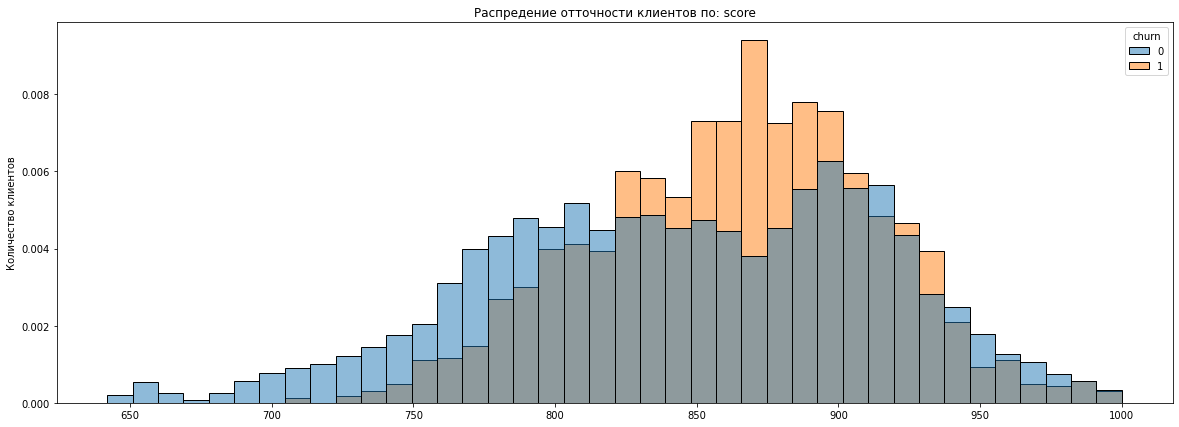

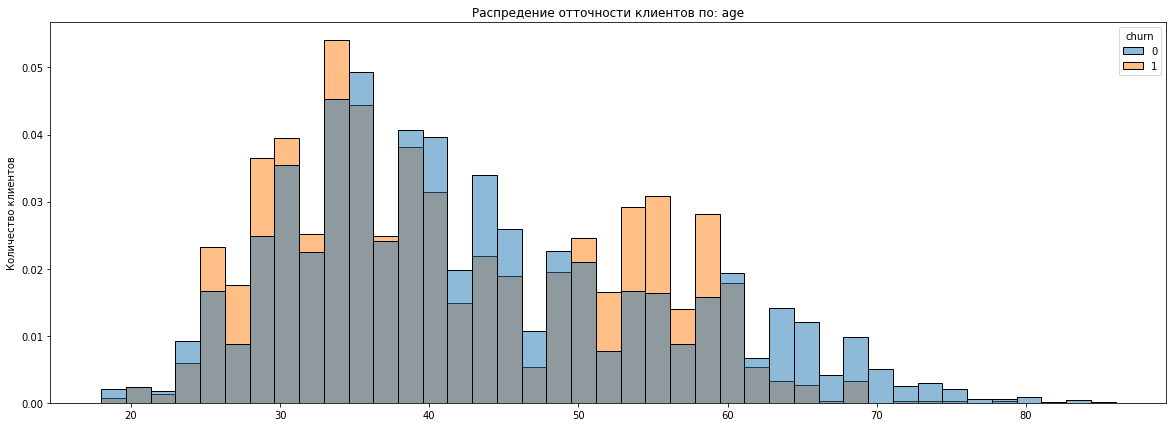

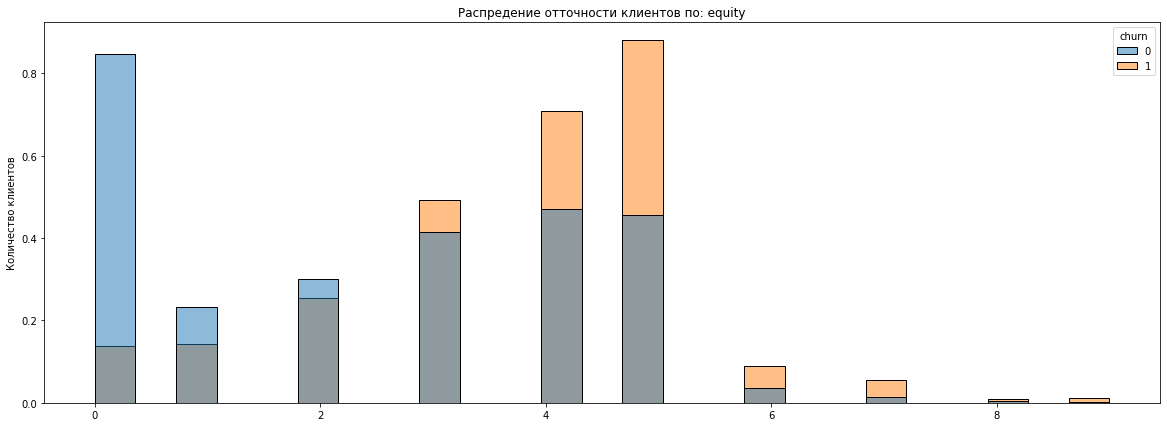

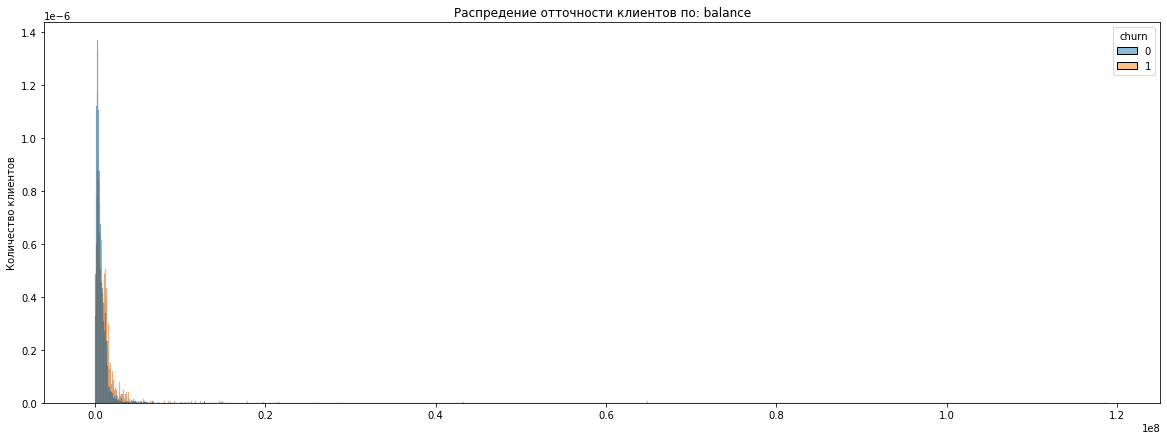

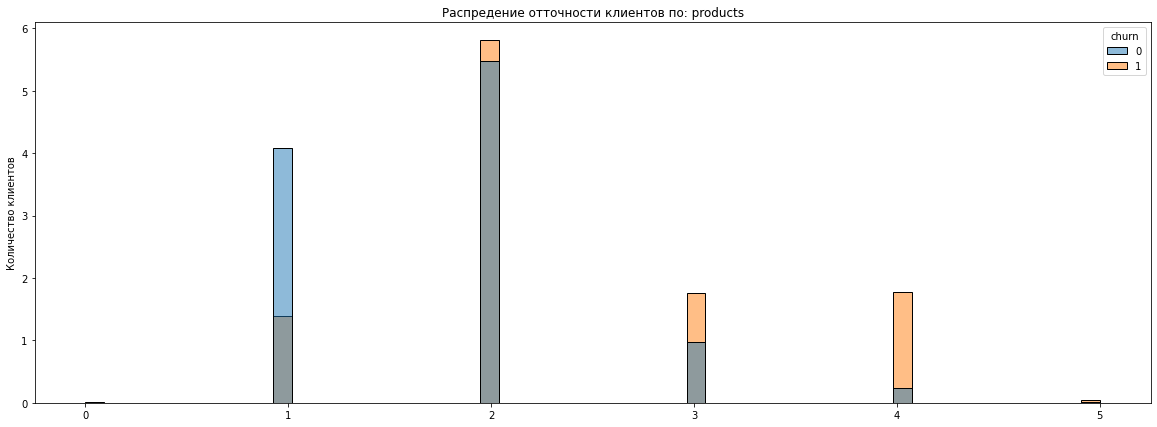

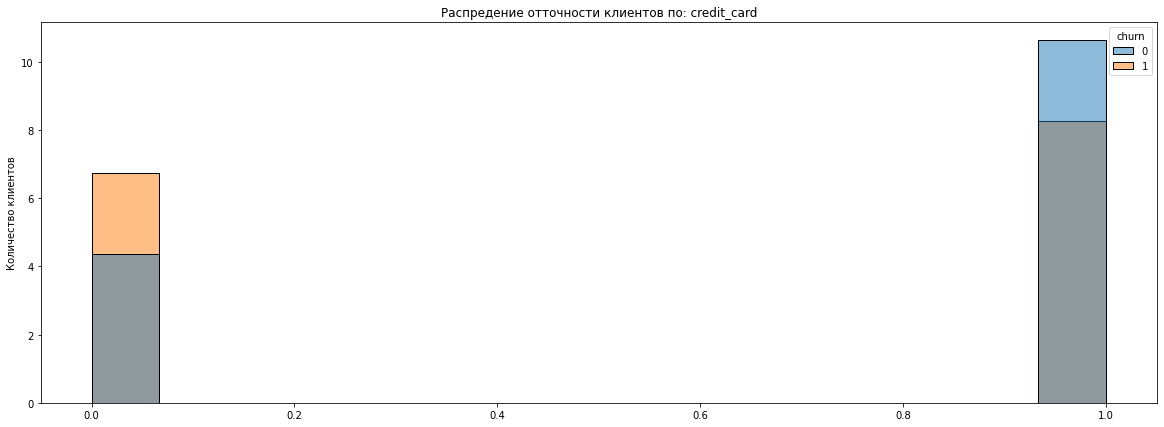

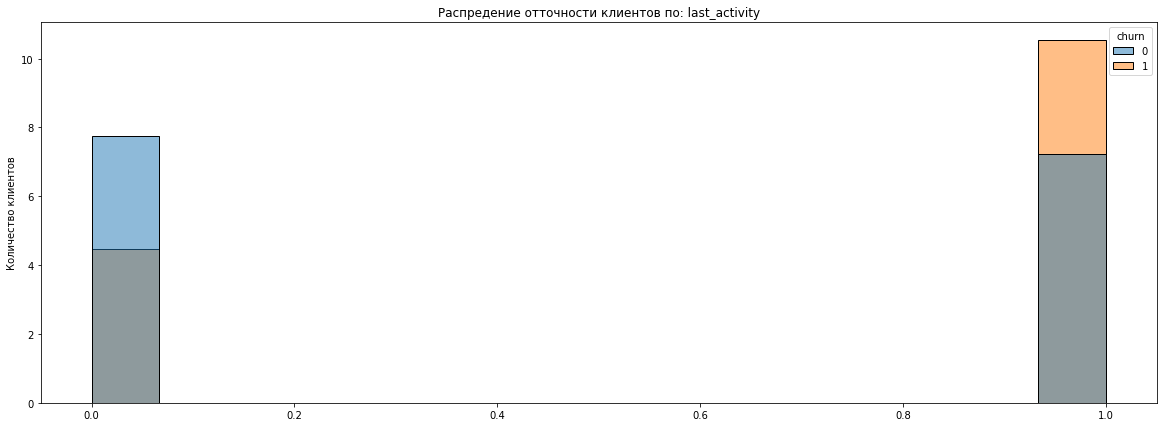

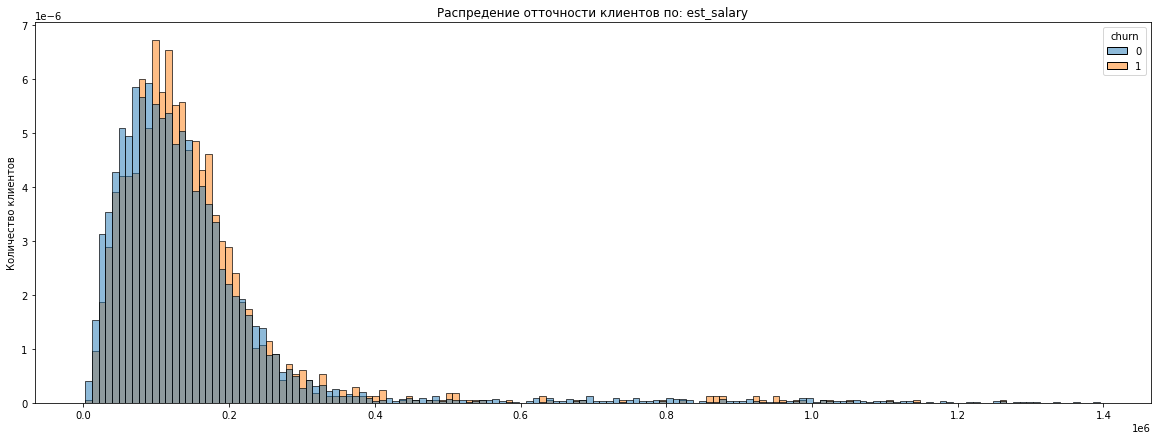

In [51]:
plots(data)

Из графиков видно, что наиболее сильный отток клиентов:
 - баллы кредитного скоринга в диапазоне 820-940
 - в возрасте 25-35 лет и 50-60 лет;
 - с оценкой собственности 3 и выше;
 - при использовании 2 и более продуктов;
 - без кредитной карты и более активные в последнее время.

 
Графики с балансом и зарплатой получились не совсем информативные. Сделаем срезы по 99 процентилю и рассмотрим поближе.

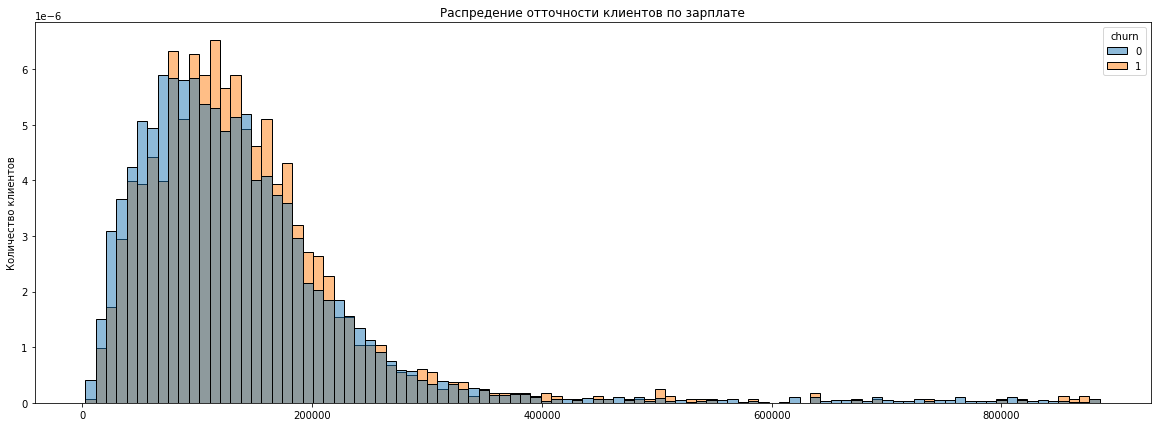

In [52]:
#делаем срез по зарплате
data_salary_99_p = data.query('est_salary < 886322.53')

#построим график по срезу
plt.figure(figsize=(20,7))
sns.histplot(data=data_salary_99_p, x='est_salary', hue='churn', stat="density", common_norm=False);
plt.title(f'Распредение отточности клиентов по зарплате')
plt.xlabel('')
plt.ylabel('Количество клиентов')
plt.show()

Судя по графику можно сказать, что в основном отток идет в диапазоне от 100 000 р. до 210 000р, далее есть как отточные клиенты так и нет.

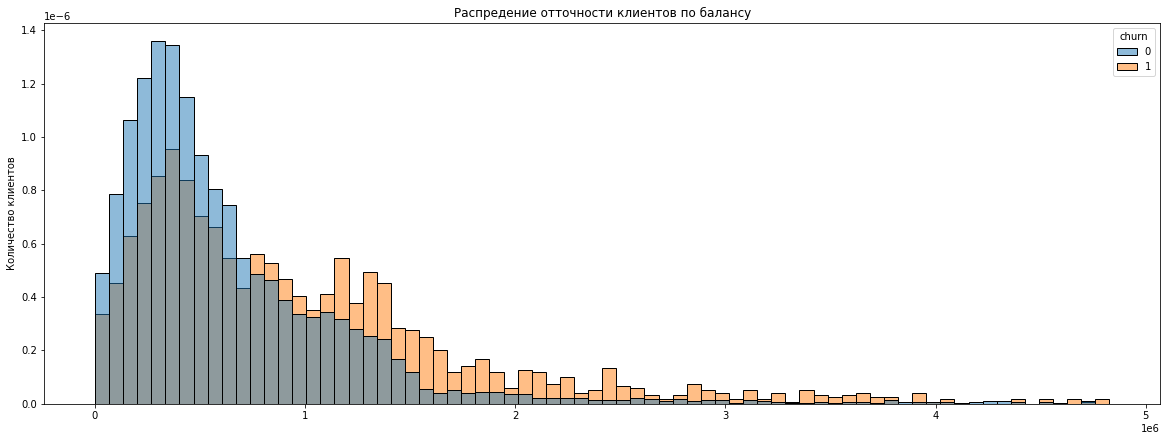

In [53]:
#делаем срез по балансу
data_balance_99_p = data.query('balance < 4827211.16')

#построим график по срезу
plt.figure(figsize=(20,7))
sns.histplot(data=data_balance_99_p, x='balance', hue='churn', stat='density', common_norm=False);
plt.title(f'Распредение отточности клиентов по балансу')
plt.xlabel('')
plt.ylabel('Количество клиентов')
plt.show()

Мы видим отток примерно с 700 000р на балансе клиента.


Посмотрим долю ушедших клиентов по городам

In [54]:
data_city = data.groupby('city').agg({'user_id' : 'count', 'churn' : 'sum'}).reset_index() 
data_city.columns = ['city', 'total', 'churn']
data_city['perc'] = data_city['churn']/data_city['total']*100
data_city = data_city.round(1).sort_values(by='perc', ascending=False)
data_city

,city,total,churn,perc
2,Ярославль,5875,1117,19.0
0,Ростов,1416,265,18.7
1,Рыбинск,2683,437,16.3


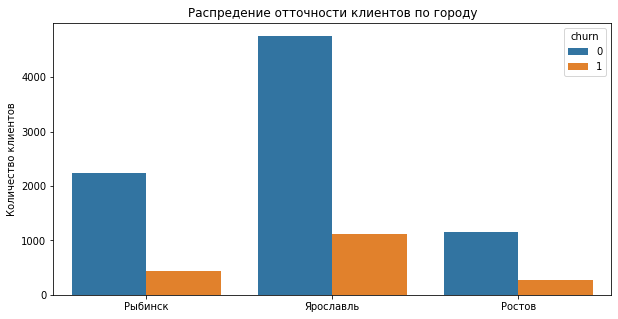

In [55]:
#построим гистограмму
plt.figure(figsize=(10, 5))
#sns.histplot(data=data, hue='churn', x='gender', stat='density', common_norm=False, palette='flag')
sns.countplot(x = 'city', hue = 'churn', data = data)
plt.title('Распредение отточности клиентов по городу')
plt.xlabel('')
plt.ylabel('Количество клиентов')
plt.show()

Больше всего клиентов в г. Ярославль, в том числе там самый высокий процент оттока(19%), в Ростове отток - 18,7%, а в Рыбинске - 16,3%.


Рассмотрим распределение в зависимости от пола.

In [56]:
data_gender = data.groupby('gender').agg({'user_id' : 'count', 'churn' : 'sum'}).reset_index() 
data_gender.columns = ['gender', 'total', 'churn']
data_gender['perc'] = data_gender['churn']/data_gender['total']*100
data_gender = data_gender.round(1).sort_values(by='perc', ascending=False)
data_gender

,gender,total,churn,perc
1,М,4991,1183,23.7
0,Ж,4983,636,12.8


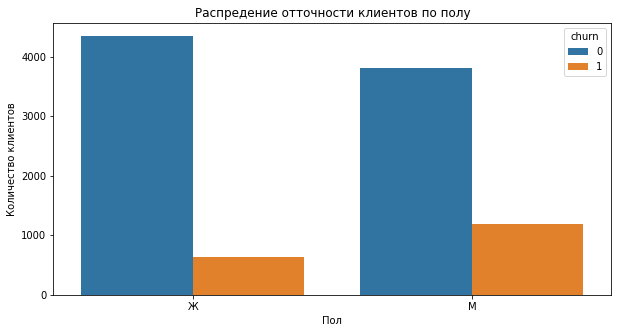

In [57]:
#построим гистограмму
plt.figure(figsize=(10, 5))
#sns.histplot(data=data, hue='churn', x='gender', stat='density', common_norm=False, palette='flag')
sns.countplot(x = 'gender', hue = 'churn', data = data)
plt.title('Распредение отточности клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.show()

Женщин и мужчин примерно одиноковое количество, однако отток мужчин почти в два раза выше женщин - 23,7%, тогда как женщин 12,8%

Вывод.

Портрет клиента банка:

- Одинаковое количество мужчин и женщин
- Большее количество клиентов проживает в Ярославле
- Средний скоринговый балл приблизительно 850
- Возраст 30-40 лет
- Средняя оценка собственности 2,6
- В основном используют 1-2 продукта
- Есть кредитная карта и клиент активный
- Медианный баланс приблизительно 520 т.р.
- Медианная зарплата равна 120 т.р.

Портрет отточного клиента:

- В основном попадают в отток мужчины
- Отточные клиенты проживают чаще в Ярославле(19%) и Ростове(18,7%)
- Возраст 25-35 лет или 50-60 лет
- Со скоринговым баллом в диапазоне 820-940
- С оценкой собственности 3 и выше
- Используют 2 и более продуктов
- Не имеют кредитной карты и более активные в последнее время
- С зарплатой от 100т.р.до 200т.р.
- Балансом от 700т.р. и выше.




Построим матрицу корреляции

Для построения будем использовать коэфициент Phik.

Поскольку столбец `user_id` не является признаком и не должен попасть в расчет корреляции удалим его.

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


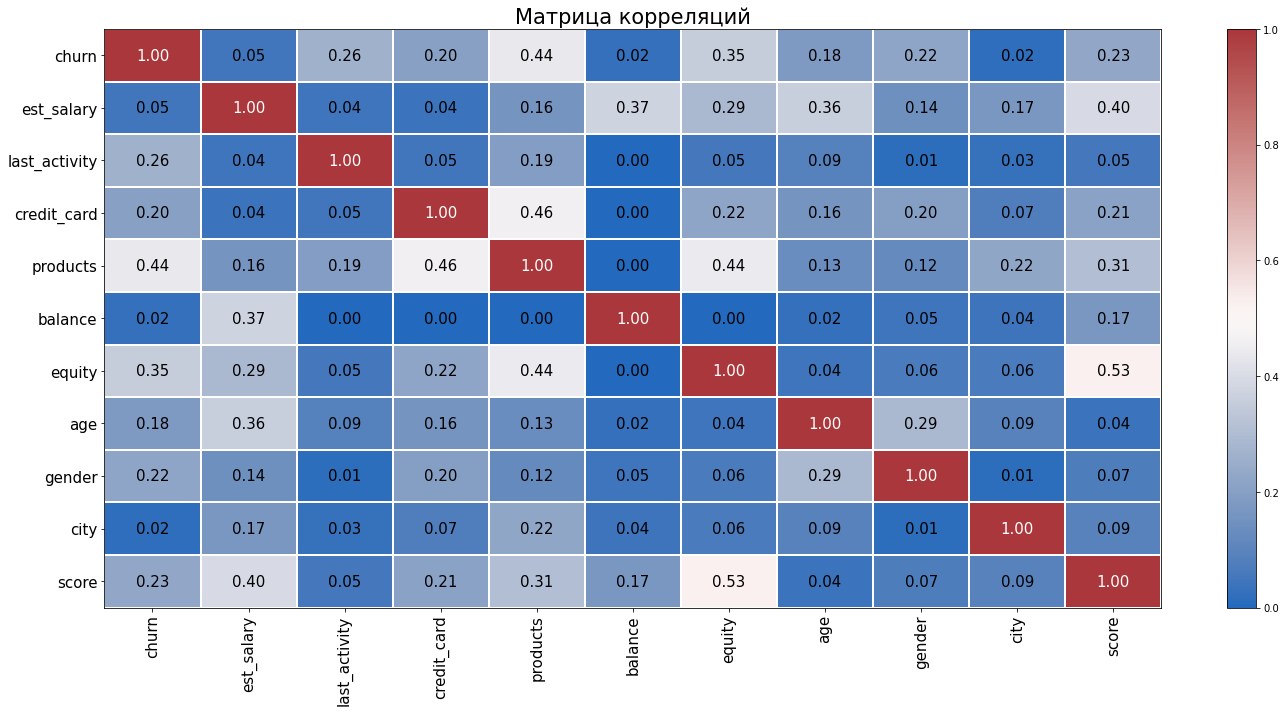

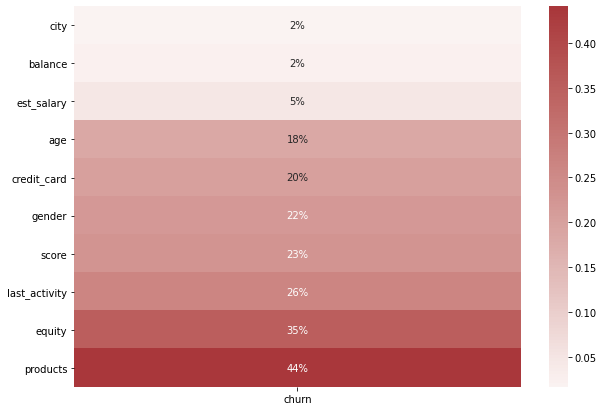

In [58]:
# удаляем столбец user_id
data_remade = data.drop(columns='user_id') 

#создадим таблицу для матрицы
data_corr = data_remade.phik_matrix()

#построим матрицу
plot_correlation_matrix(data_corr.values, 
                        x_labels=data_corr.columns, 
                        y_labels=data_corr.index, 
                        vmin=0, vmax=1, color_map='vlag', 
                        title='Матрица корреляций', 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))


# добавим график только с одним столбцом оттока
plt.figure(figsize=(10, 7))
sns.heatmap(data_corr.loc[:,['churn']].drop('churn').sort_values('churn'), annot=True, fmt='.0%', cmap='vlag', center=0);

Из графиков мы видим, что нет сильной связи с оттоком. 

В порядке убывания с оттоком коррелирует:
- Умеренная корреляция оттока и количества продуктов - 44%
- Умеренная корреляция оттока и оценки собственности - 35%
- Слабая корреляция оттока и активности клиента - 26%
- Слабая корреляция оттока и баллов скоринга- 23%
- Слабая корреляция оттока и пола- 22%


Выделим несколько наиболее отточный сегментов.

Поскольку мы выяснили,что наиболее отточные клиенты проживают в Ярославле и Ростове и это мужчины. Рассмотрим их + еще один отточный признак. Сделаем необходимые срезы.

In [59]:
# делаем срез по возрасту от 25 до 35 лет
data_1 = data.query('gender == "М" and 25 < age < 35 and city != "Рыбинск"')
# делаем срез по возрасту от 50 до 60 лет
data_2 = data.query('gender == "М" and 50 < age < 60 and city != "Рыбинск"')
#делаем срез по кредитной карты
data_3 = data.query('gender == "М" and credit_card == 0 and city != "Рыбинск"')
#делаем срез по количеству продуктов от 2 и более
data_4 = data.query('gender == "М" and products >= 2 and city != "Рыбинск"')
#делаем срез по балансу более 700000р
data_5 = data.query('gender == "М" and balance > 700000 and city != "Рыбинск"')
#делаем срез по зарплате от 100000р до 200000р
data_6 = data.query('gender == "М" and 100000<est_salary < 200000 and city != "Рыбинск"')
#делаем срез по кредитному скорингу в диапазоне 820-940 баллов
data_7 = data.query('gender == "М" and 820<score<940 and city != "Рыбинск"')
#делаем срез оценке собственности от 3
data_8 = data.query('gender == "М" and equity >=3 and city != "Рыбинск"')
#делаем срез по активности клиента в последнее время
data_9 = data.query('gender == "М" and last_activity==1 and city != "Рыбинск"')

In [60]:
# функция для выделения сегментов 

data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9]
#mean_churn_of_bank = data['churn'].mean()

def segment(data):
    for data in data_list:
        print()
        print('Численность сегмента: ', len(data))
        data_churn = data.groupby('gender').agg({'user_id' : 'count', 'churn' : 'sum'}).reset_index() 
        data_churn.columns = ['gender', 'total', 'churn']
        data_churn['perc'] = data_churn['churn']/data_churn['total']*100
        data_churn = data_churn.round(1).sort_values(by='perc', ascending=False)
        print(data_churn)

In [61]:
segment(data)


Численность сегмента:  1112
  gender  total  churn  perc
0      М   1112    290  26.1

Численность сегмента:  441
  gender  total  churn  perc
0      М    441    163  37.0

Численность сегмента:  890
  gender  total  churn  perc
0      М    890    332  37.3

Численность сегмента:  2333
  gender  total  churn  perc
0      М   2333    759  32.5

Численность сегмента:  1103
  gender  total  churn  perc
0      М   1103    508  46.1

Численность сегмента:  1635
  gender  total  churn  perc
0      М   1635    410  25.1

Численность сегмента:  2164
  gender  total  churn  perc
0      М   2164    645  29.8

Численность сегмента:  2012
  gender  total  churn  perc
0      М   2012    729  36.2

Численность сегмента:  1843
  gender  total  churn  perc
0      М   1843    555  30.1


Расставим сегменты в порядке убывания оттока. Выберем 5-ку лидеров:
1. Мужчины с балансом более 700 000р. (46,1%)
2. Мужчины без кредитной карты (37,3%)
3. Мужчины от 50 до 60 лет (37%)
4. Мужчины с оценкой собственности в 3 балла и выше (36,2%)
5. Мужчины с двумя и более продуктами (32,5%)

### Статистический анализ

Проверка гипотез

Гипотеза о различиях скоринговых баллах между теми клиентами, которые ушли и теми, которые остались.

Проверим данные на нормальность.

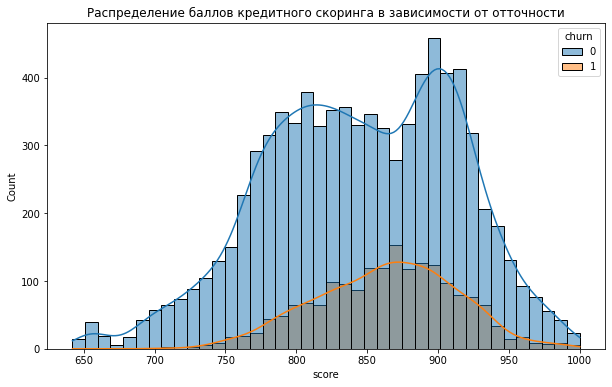

In [62]:
#построим график
plt.figure(figsize=(10, 6)) 

sns.histplot(data=data, x='score', hue='churn', kde=True)#
plt.title('Распределение баллов кредитного скоринга в зависимости от отточности')
plt.show()

Данные распределены нормально. 

Посмотрим значения у обеих выборок

In [63]:
data_stay_sc = data[data['churn'] == 0]['score']
data_stay_sc.describe()

count    8155.000000
mean      845.396199
std        67.993107
min       642.000000
25%       796.000000
50%       848.000000
75%       900.000000
max      1000.000000
Name: score, dtype: float64

In [64]:
data_churn_sc = data[data['churn'] == 1]['score']
data_churn_sc.describe()

count    1819.000000
mean      863.416163
std        49.620984
min       706.000000
25%       828.000000
50%       866.000000
75%       898.000000
max      1000.000000
Name: score, dtype: float64

Выведем основную и альтернативную гипотезы:

- H0: Баллы кредитного скоринга у отточных клиентов, и у тех которые остались одинаковы.
- H1: Баллы кредитного скоринга у отточных клиентов, и у тех которые остались отличаются.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод `scipy.ttest_ind (array1, array2, equal_var)`. 

Поскольку нет уверенности в равных дисперсиях в параметре `equal_var` будем использовать `False`

Уровень значимости зададим alpha = 0.05

Если p-value будет меньше выбранного уровня значимости, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [65]:
alpha = .05 # задаем уровень стат. значимости  

results = st.ttest_ind(data_stay_sc, data_churn_sc, equal_var=False) # стат. тест о равенстве 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.60332714629934e-38
Отвергаем нулевую гипотезу


Cредний скоринговый балл у отточных клиентов и клиентов которые остались разный.

Проверим статистическую гипотезу о различиях дохода между теми клиентами, которые ушли и теми, которые остались.

Проверим данные на нормальность.

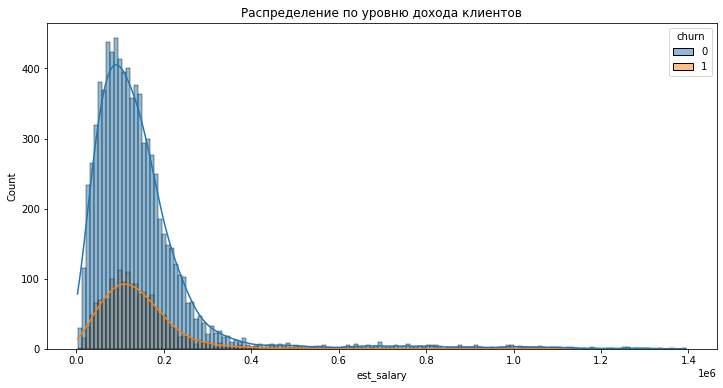

In [66]:
#строим график
plt.figure(figsize=(12, 6))

sns.histplot(data=data, x='est_salary', hue='churn', kde=True)#
plt.title('Распределение по уровню дохода клиентов')
plt.show()

Данные распределены не нормально. 


In [69]:
data_stay_es = data[data['churn'] == 0]['est_salary']
data_stay_es.describe()

count    8.155000e+03
mean     1.476746e+05
std      1.426844e+05
min      2.546300e+03
25%      7.344555e+04
50%      1.182276e+05
75%      1.739609e+05
max      1.395064e+06
Name: est_salary, dtype: float64

In [70]:
data_churn_es = data[data['churn'] == 1]['est_salary']
data_churn_es.describe()

count    1.819000e+03
mean     1.482897e+05
std      1.229322e+05
min      1.088027e+04
25%      8.319661e+04
50%      1.253952e+05
75%      1.759854e+05
max      1.263028e+06
Name: est_salary, dtype: float64

Выведем основную и альтернативную гипотезы:

- H0: Доход у отточных клиентов, и у тех которые остались одинаковый.
- H1: Доход у отточных клиентов, и у тех которые остались отличается.

Поскольку данные распределены не нормально будем применять непараметрический метод Манна-Уитни. В отличие от t-критерия Стьюдента, метод Манна-Уитни не требует наличия нормального распределения сравниваемых совокупностей.

Уровень значимости зададим alpha = 0.05

Если p-value будет меньше выбранного уровня значимости, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [77]:
alpha = .05 # задаем уровень стат. значимости  

#results = st.ttest_ind(data_churn_es, data_stay_es, equal_var=False) # стат. тест о равенстве 
results = st.mannwhitneyu(data_churn_es, data_stay_es)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0001941125216825749
Отвергаем нулевую гипотезу


Доход у отточных клиентов, и у тех которые остались отличается.


### Вывод и рекомендации

В ходе исследования был проанализирован датасет банка «Метанпром». 

Была выполнена предобработка данных, исследовательский и статистический анализ.

Общий портрет клиента банка:

- Одинаковое количество мужчин и женщин
- Большее количество клиентов проживает в Ярославле
- Средний скоринговый балл приблизительно 850
- Возраст 30-40 лет
- Средняя оценка собственности 2,6
- В основном используют 1-2 продукта
- Есть кредитная карта и клиент активный
- Медианный баланс приблизительно 520 т.р.
- Медианная зарплата равна 120 т.р.

Портрет отточного клиента:

- В основном попадают в отток мужчины
- Отточные клиенты проживают чаще в Ярославле(19%) и Ростове(18,7%)
- Возраст 25-35 лет или 50-60 лет
- Со скоринговым баллом в диапазоне 820-940
- С оценкой собственности 3 и выше
- Используют 2 и более продуктов
- Не имеют кредитной карты и более активные в последнее время
- С зарплатой от 100т.р.до 200т.р.
- Балансом от 700т.р. и выше.

Сильнее всего с оттоком коррелирует количество продуктов - 44%

Были выделены несколько сегментов как самые отточные.
Мужчины из городов Ярославль и Ростов.

5-ка лидеров:
1. Мужчины с балансом более 700 000р. (46,1%)
2. Мужчины без кредитной карты (37,3%)
3. Мужчины от 50 до 60 лет (37%)
4. Мужчины с оценкой собственности в 3 балла и выше (36,2%)
5. Мужчины с двумя и более продуктами (32,5%)

Также были проверены две гипотезы:
 - Гипотеза о различиях скоринговых баллах между теми клиентами, которые ушли и теми, которые остались.
   - Cредний скоринговый балл у отточных клиентов и клиентов которые остались разный.
 
 - Гипотеза о различиях доходов между теми клиентами, которые ушли и теми, которые остались.
   - Доход у отточных клиентов, и у тех которые остались отличается.
 


Рекомендации.

На этапе предобработки данных были выявлены дубликаты в id клиентов которые должны быть уникальными. Остальные данные у дубликатов были разные, вероятно это связано с некорректным заполнением базы данных. Или с тем, что у городов были разные базы клиентов. Необходимо понять причину, для дальнейшего корректного заполнения баз. Необходимо узнать причину пропусков в балансе. 

Выделив отточные сегменты мы видим, что это в основном мужчины. Надо попробовать получить обратную связь от них. У мужчин возрастом 50-60 лет(предпенсионер), возможно добавить какие то льготы или бонусы как у пенсионеров, например кэшбек за покупки продуктов питания при оплате картой банка, чтобы их удержать. Молодым мужчинам 25-35 лет, возможно нужно предложить льготную ставку (как молодым семьям, хотя в данных не было указано семейного статуса) на ипотеку. Клиентам без кредитной карты можно предложить более выгодные условия, например добавить льготный период(или увеличить если он есть). Клиентам у которых более двух продуктов, возможно это несколько кредитов(в датасете не указано какие именно это продукты) можно предложить объединение кредитов в один и улучшение ставки. Клиентов с балансом более 700000р возможно не устраивает ставка по вкладам, можно пересмотреть ставку в зависимости от суммы и предложить лучшие условия. Также можно изучить предложения конкуретных банков в этих городах.